## Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, kl_divergence
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time


In [ ]:
!pip install numpyro jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 13.3 MB/s eta 0:00:00


# Bayesian Neural Nework with Hamiltonian Monte Carlo

## Generate Synthetic Data

In [ ]:
# Generates synthetic linear data
def generate_linear_data(n_samples=1000, noise_std=0.1):

    X = np.random.uniform(-5, 5, size=(n_samples, 1))
    y = 2 * X + 1 + np.random.normal(0, noise_std, size=X.shape)

    return X.astype(np.float32), y.astype(np.float32)

# Generates synthetic nonlinear (sine) data
def generate_nonlinear_data(n_samples=1000, noise_std=0.1):

    X = np.random.uniform(-5, 5, size=(n_samples, 1))
    y = np.sin(X) + np.random.normal(0, noise_std, size=X.shape)

    return X.astype(np.float32), y.astype(np.float32)


## Define Bayesian Neural Network

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import matplotlib.pyplot as plt

In [ ]:
def bayesian_nn_model(X, Y=None, hidden_dim=64):
    input_dim = X.shape[1]

    # Priors on weights and biases
    w1 = numpyro.sample("w1", dist.Normal(0, 1).expand([input_dim, hidden_dim]))
    b1 = numpyro.sample("b1", dist.Normal(0, 1).expand([hidden_dim]))
    w2 = numpyro.sample("w2", dist.Normal(0, 1).expand([hidden_dim, 1]))
    b2 = numpyro.sample("b2", dist.Normal(0, 1).expand([1]))

    # Neural network forward pass
    z1 = jnp.tanh(jnp.dot(X, w1) + b1)
    preds = jnp.dot(z1, w2) + b2
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))

    # Likelihood
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Normal(preds.squeeze(), sigma), obs=Y)


## Define Training Function

In [ ]:
def train_bnn_hmc(X_train, y_train, num_samples=1000, num_warmup=500, rng_seed=0):
    X_train = jnp.array(X_train)
    y_train = jnp.array(y_train).squeeze()

    kernel = NUTS(bayesian_nn_model)
    mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup)

    start = time.time()
    mcmc.run(jax.random.PRNGKey(rng_seed), X=X_train, Y=y_train)
    end = time.time()

    return mcmc.get_samples(), round(end - start, 3)


## Define Prediction and Evaluation Functions


In [ ]:
def predict_bnn(samples, X_test):
    X_test = jnp.array(X_test)
    predictive = numpyro.infer.Predictive(bayesian_nn_model, posterior_samples=samples, return_sites=["obs"])
    preds = predictive(jax.random.PRNGKey(1), X=X_test)["obs"]  # Shape: [num_samples, batch_size]
    return np.array(preds)


In [ ]:
def evaluate_bnn(samples, X_test, y_test, training_time):
    preds = predict_bnn(samples, X_test)
    mean_preds = np.mean(preds, axis=0)
    std_preds = np.std(preds, axis=0)

    lower = mean_preds - 1.96 * std_preds
    upper = mean_preds + 1.96 * std_preds

    mse = mean_squared_error(y_test, mean_preds)
    mae = mean_absolute_error(y_test, mean_preds)
    r2 = r2_score(y_test, mean_preds)
    coverage = np.mean((y_test >= lower) & (y_test <= upper))
    interval_width = np.mean(upper - lower)
    accuracy = 1 - (mae / (np.max(y_test) - np.min(y_test)))

    return {
        "MSE": mse,
        "MAE": mae,
        "R2": r2,
        "Training Time (s)": training_time,
        "Coverage": coverage,
        "Interval Width": interval_width,
        "Accuracy": accuracy
    }, mean_preds, lower, upper


## Define Visualization Function

In [ ]:
def plot_bnn_predictions(X_test, y_test, mean_preds, lower, upper, title="Bayesian NN Predictions"):
    sorted_idx = np.argsort(X_test[:, 0])
    X_sorted = X_test[sorted_idx]
    y_sorted = y_test[sorted_idx]
    mean_sorted = mean_preds[sorted_idx]
    lower_sorted = lower[sorted_idx]
    upper_sorted = upper[sorted_idx]

    plt.figure(figsize=(10, 5))
    plt.plot(X_sorted[:, 0], y_sorted, 'k.', label='True')
    plt.plot(X_sorted[:, 0], mean_sorted, 'b-', label='Mean Prediction')
    plt.fill_between(X_sorted[:, 0], lower_sorted, upper_sorted, color='orange', alpha=0.2, label='Prediction Interval')
    plt.legend()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()


## Run Experiment for Bayesian Neural Network (HMC) (Linear Data)

In [ ]:
# Generate data
X, y = generate_linear_data(n_samples=500, noise_std=0.2)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train BNN
samples, training_time = train_bnn_hmc(X_train, y_train, num_samples=500, num_warmup=300)

# Evaluate
metrics, mean_preds, lower, upper = evaluate_bnn(samples, X_test, y_test, training_time)

print("Bayesian NN Evaluation:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


sample: 100%|██████████| 800/800 [03:03<00:00,  4.35it/s, 1023 steps of size 1.35e-03. acc. prob=0.91]


Bayesian NN Evaluation:
MSE: 0.0463
MAE: 0.1794
R2: 0.9986
Training Time (s): 184.0600
Coverage: 0.0495
Interval Width: 0.7875
Accuracy: 0.9909


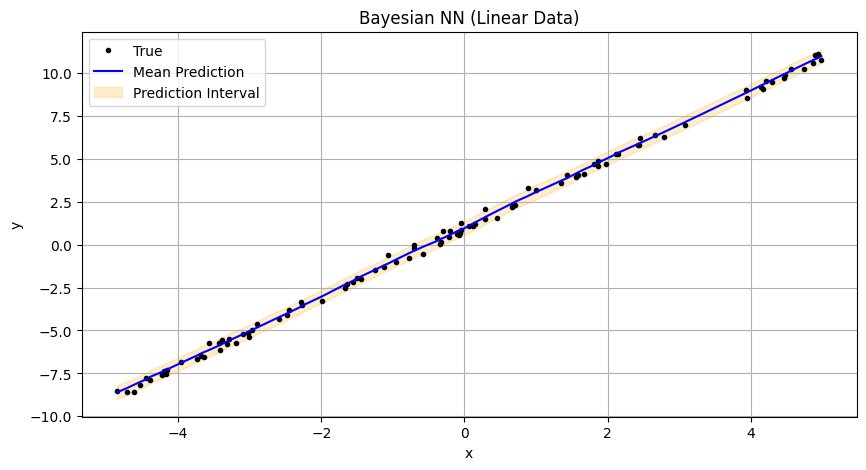

In [ ]:
# Visualize
plot_bnn_predictions(X_test, y_test, mean_preds, lower, upper, title="Bayesian NN (Linear Data)")

## Run Experiment for Bayesian Neural Network (HMC) (Nonlinear Data)

In [ ]:
# Generate data
X, y = generate_nonlinear_data(n_samples=500, noise_std=0.2)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train BNN
samples, training_time = train_bnn_hmc(X_train, y_train, num_samples=500, num_warmup=300)

# Evaluate
metrics, mean_preds, lower, upper = evaluate_bnn(samples, X_test, y_test, training_time)

print("Bayesian NN Evaluation:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


sample: 100%|██████████| 800/800 [02:57<00:00,  4.51it/s, 1023 steps of size 5.02e-03. acc. prob=0.91]


Bayesian NN Evaluation:
MSE: 0.7407
MAE: 0.6844
R2: 0.3613
Training Time (s): 177.6600
Coverage: 0.7901
Interval Width: 3.2880
Accuracy: 0.8805


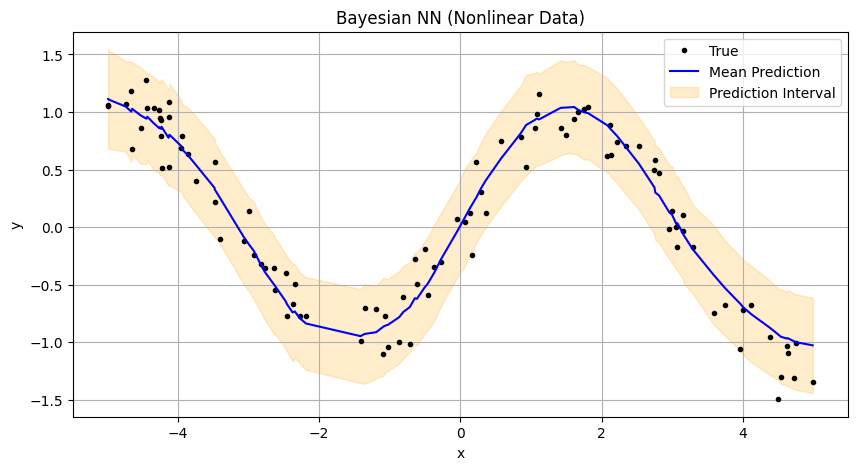

In [ ]:
# Visualize
plot_bnn_predictions(X_test, y_test, mean_preds, lower, upper, title="Bayesian NN (Nonlinear Data)")

# Bayesian Neural Network with Stochastic Gradient Variational Bayes

## Define the Bayesian Linear Layer

In [ ]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_std=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Learnable weight and bias parameters for posterior
        # Mean of the approximate posterior is initialized to small random values
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        # Log variances are initialized a small negative number to represent low initial variance
        self.weight_logvar = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-5.0))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.bias_logvar = nn.Parameter(torch.Tensor(out_features).fill_(-5.0))

        # Defines a standard Gaussian prior over the weights and biases
        self.prior = Normal(0, prior_std)

    def forward(self, input):
        # Sample weights and biases using reparameterization trick
        # Converting log variance to variance by taking the exponent and square root
        weight_std = torch.exp(0.5 * self.weight_logvar)
        bias_std = torch.exp(0.5 * self.bias_logvar)

        # Sampling weights and biases from the variational posterior
        weight = self.weight_mu + weight_std * torch.randn_like(self.weight_mu)
        bias = self.bias_mu + bias_std * torch.randn_like(self.bias_mu)

        # Apply sampled weight and bias to the input like a normal linear layer
        # Weights and biases are sampled each time, which introduced uncertainity to predictions
        return F.linear(input, weight, bias)

    def kl_loss(self):
        # Create normal distributions representing posterior over weights and biases
        weight_post = Normal(self.weight_mu, torch.exp(0.5 * self.weight_logvar))
        bias_post = Normal(self.bias_mu, torch.exp(0.5 * self.bias_logvar))

        # Calculate element-wise KL divergence as part of the ELBO
        kl = kl_divergence(weight_post, self.prior).sum() + kl_divergence(bias_post, self.prior).sum()
        return kl


## Define the Bayesian Neural Network

In [ ]:
class BayesianNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.fc1 = BayesianLinear(input_dim, hidden_dim)
        self.fc2 = BayesianLinear(hidden_dim, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

    def kl_loss(self):
        return self.fc1.kl_loss() + self.fc2.kl_loss()


## Define Training Function

In [ ]:
def train_sgvb(model, X_train, y_train, num_epochs=2000, lr=1e-3, num_samples=3, beta=1.0):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    start = time.time()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        likelihood = 0
        kl = 0
        for _ in range(num_samples):
            outputs = model(X_train)
            likelihood += F.mse_loss(outputs, y_train, reduction='sum')
            kl += model.kl_loss()
        # Calculate ELBO
        elbo = -(likelihood / num_samples + beta * kl)
        loss = -elbo / len(X_train)
        loss.backward()
        optimizer.step()

    end = time.time()
    return round(end - start, 3)


## Define Prediction and Evaluation Functions

In [ ]:
def predict_sgvb(model, X_test, num_samples=100):
    model.eval()
    X_test = torch.tensor(X_test, dtype=torch.float32)
    preds = []

    with torch.no_grad():
        for _ in range(num_samples):
            preds.append(model(X_test).squeeze().cpu().numpy())

    return np.array(preds)


In [ ]:
def evaluate_sgvb(preds, y_test, training_time):
    mean_preds = np.mean(preds, axis=0)
    std_preds = np.std(preds, axis=0)

    lower = mean_preds - 1.96 * std_preds
    upper = mean_preds + 1.96 * std_preds

    mse = mean_squared_error(y_test, mean_preds)
    mae = mean_absolute_error(y_test, mean_preds)
    r2 = r2_score(y_test, mean_preds)
    coverage = np.mean((y_test >= lower) & (y_test <= upper))
    interval_width = np.mean(upper - lower)
    accuracy = 1 - (mae / (np.max(y_test) - np.min(y_test)))

    return {
        "MSE": mse,
        "MAE": mae,
        "R2": r2,
        "Training Time (s)": training_time,
        "Coverage": coverage,
        "Interval Width": interval_width,
        "Accuracy": accuracy
    }, mean_preds, lower, upper


## Define Visualization Function

In [ ]:
def plot_sgvb_predictions(X_test, y_test, mean_preds, lower, upper, title="SGVB Bayesian NN Predictions"):
    sorted_idx = np.argsort(X_test[:, 0])
    X_sorted = X_test[sorted_idx]
    y_sorted = y_test[sorted_idx]
    mean_sorted = mean_preds[sorted_idx]
    lower_sorted = lower[sorted_idx]
    upper_sorted = upper[sorted_idx]

    plt.figure(figsize=(10, 5))
    plt.plot(X_sorted[:, 0], y_sorted, 'k.', label='True')
    plt.plot(X_sorted[:, 0], mean_sorted, 'b-', label='Mean Prediction')
    plt.fill_between(X_sorted[:, 0], lower_sorted, upper_sorted, color='orange', alpha=0.2, label='Prediction Interval')
    plt.legend()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()


## Run Experiment for Bayesian Neural Network (SGVB) (Linear Data)

SGVB Bayesian NN Evaluation:
MSE: 0.2978
MAE: 0.4465
R2: 0.9905
Training Time (s): 21.3550
Coverage: 0.1525
Interval Width: 2.6413
Accuracy: 0.9777


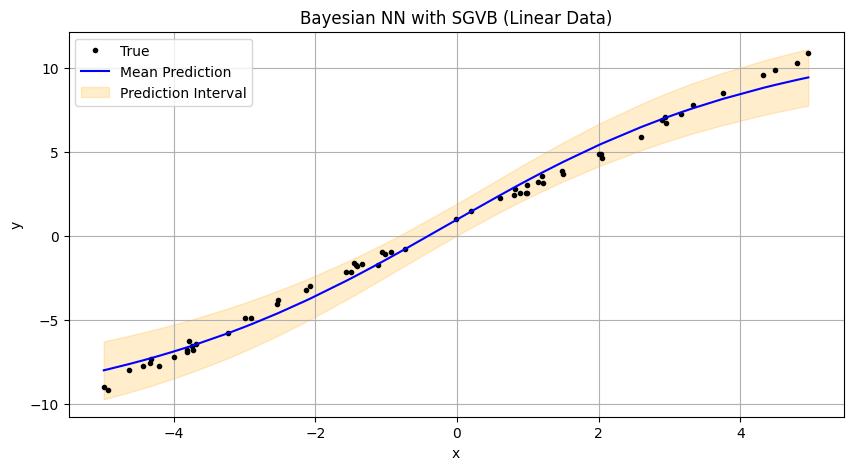

In [ ]:
# Generate data
X, y = generate_linear_data(n_samples=300, noise_std=0.2)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train model
model = BayesianNN(input_dim=1, hidden_dim=64)
training_time = train_sgvb(model, X_train, y_train, num_epochs=3000)

# Predict
preds = predict_sgvb(model, X_test, num_samples=100)

# Evaluate
metrics, mean_preds, lower, upper = evaluate_sgvb(preds, y_test, training_time)
print("SGVB Bayesian NN Evaluation:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Visualize
plot_sgvb_predictions(X_test, y_test, mean_preds, lower, upper, title="Bayesian NN with SGVB (Linear Data)")


## Run Experiment for Bayesian Neural Network (SGVB) (Nonlinear Data)

SGVB Bayesian NN Evaluation:
MSE: 0.7064
MAE: 0.6716
R2: 0.3674
Training Time (s): 19.8970
Coverage: 0.6107
Interval Width: 2.1238
Accuracy: 0.8634


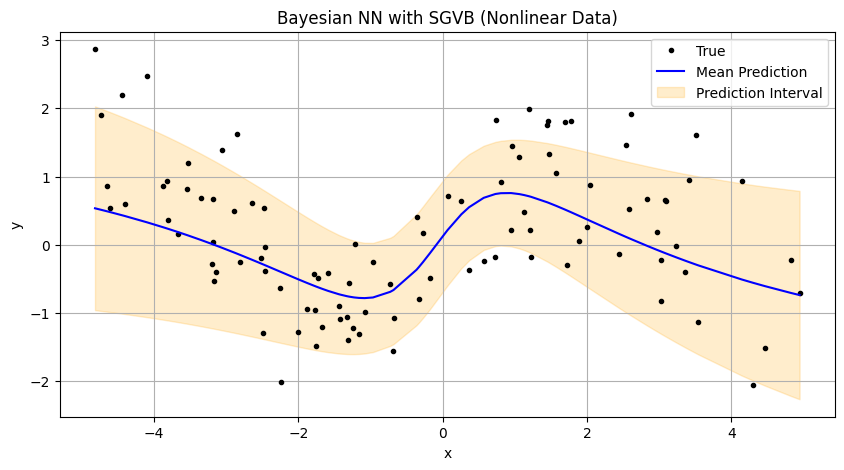

In [ ]:
# Generate data
X, y = generate_nonlinear_data(n_samples=500, noise_std=0.8)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train model
model = BayesianNN(input_dim=1, hidden_dim=64)
training_time = train_sgvb(model, X_train, y_train, num_epochs=3000)

# Predict
preds = predict_sgvb(model, X_test, num_samples=100)

# Evaluate
metrics, mean_preds, lower, upper = evaluate_sgvb(preds, y_test, training_time)
print("SGVB Bayesian NN Evaluation:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Visualize
plot_sgvb_predictions(X_test, y_test, mean_preds, lower, upper, title="Bayesian NN with SGVB (Nonlinear Data)")
